In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from glob import glob


In [2]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import time
import datetime

### 1. Classification supervisé des images avec le modèle EfficientNetV2M sans data augmentation 

- Prétatitement des images (passage au gris, réduction de taille)
- Entrainement du modèle
- Evaluation du modèle 

### 2. Classification supervisé des images avec le modèle EfficientNetV2M avec data augmentation intégré au modèle 

### 3. Classification supervisé des images avec le modèle EfficientNetV2M avec data augmentation 

- Creation de 1250 images augmentés
- Prétatitement des images (passage au gris, réduction de taille)
- Entrainement du modèle
- Evaluation du modèle 

In [3]:
df = pd.read_csv('Source/flipkart_com-ecommerce_sample_1050.csv',sep=',')

In [4]:
path_img = 'Source/Images'

In [5]:
# lire des caractère sur une image
import nltk
nltk.download('punkt')
tokenizer = nltk.RegexpTokenizer(r'\w+')
token = np.array(df.product_category_tree)

token = [tokenizer.tokenize(i.lower()) for i in token]

bigram = [list(nltk.bigrams(bigram)) for bigram in token]

token_bigram = pd.Series(bigram)

cat_name = np.array([token_bigram[i][0] for i in range(len(token_bigram))])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragomir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1 

In [7]:
df['category_name'] = df_token

In [8]:
from sklearn import preprocessing


# preprocessing encodage des données
encodage = preprocessing.LabelEncoder()
encodage.fit(df.category_name)
df["label"] = encodage.transform(df.category_name)
# data.head(5)
df.category_name.value_counts()

home         300
baby         150
watches      150
kitchen      150
beauty       150
computers    150
Name: category_name, dtype: int64

In [9]:
img = [img for img in df.image]
img_path = []

for i in range(len(img)):
    img_path.append(path_img+"/"+img[i])
    df['path_img'] = path_img+"/"+img[i]

### 1. Classification supervisé des images avec le modèle EfficientNetV2M sans data augmentation 

In [10]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = EfficientNetV2M(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    # 6 sorties correepondant aux 6 classes 
    predictions = Dense(6, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model



In [11]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in data['path'] :
        img = (load_img(image_num,target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img =preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

### Prétraitement des images (passage au gris, réduction de taille)

In [12]:

dframe = {'path':img_path[:900],'label':df.label[:900].astype(str)}
dframe = pd.DataFrame(dframe)
dframe


dftest = {'path':img_path[901:1050],'label':df.label[901:1050].astype(str)}
dftest = pd.DataFrame(dftest)
dframe_test = dftest


#images_np = image_prep_fct(dframe)
#print(images_np.shape)

In [13]:

    
images_np = image_prep_fct(dframe)
print(images_np.shape)
images_np_test = image_prep_fct(dframe_test)
print(images_np_test.shape)

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(900, 224, 224, 3)
(149, 224, 224, 3)


In [14]:
images_np.shape

(900, 224, 224, 3)

In [15]:
X = images_np
y = to_categorical(dframe['label'])

X_test = images_np_test
y_test = to_categorical(dframe_test['label'])

y

array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(675, 224, 224, 3)

In [17]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "Models/model1_best_w.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

### Entrainement du modèle 

In [18]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=15, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)



Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 0.8193 - accuracy: 0.7541
Epoch 1: val_loss improved from inf to 0.48491, saving model to Models\model1_best_w.h5
11/11 [==============================] - 115s 9s/step - loss: 0.8193 - accuracy: 0.7541 - val_loss: 0.4849 - val_accuracy: 0.8667
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.9156
Epoch 2: val_loss improved from 0.48491 to 0.43843, saving model to Models\model1_best_w.h5
11/11 [==============================] - 89s 8s/step - loss: 0.3247 - accuracy: 0.9156 - val_loss: 0.4384 - val_accuracy: 0.8622
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9393
Epoch 3: val_loss improved from 0.43843 to 0.40145, saving model to Models\model1_best_w.h5
11/11 [==============================] - 85s 8s/step - loss: 0.2201 - accuracy: 0.9393 - val_loss: 0.4015 - val_accuracy: 0.8711
Epoch 4/15
11/11 [==============================] - ETA: 0

### Evaluation du modèle

In [19]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

22/22 [==============================] - 65s 3s/step - loss: 0.0202 - accuracy: 0.9970
Training Accuracy: 0.9970

8/8 [==============================] - 22s 3s/step - loss: 0.4317 - accuracy: 0.8711
Validation Accuracy:  0.8711


In [20]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8844
Test Accuracy       :  0.7517


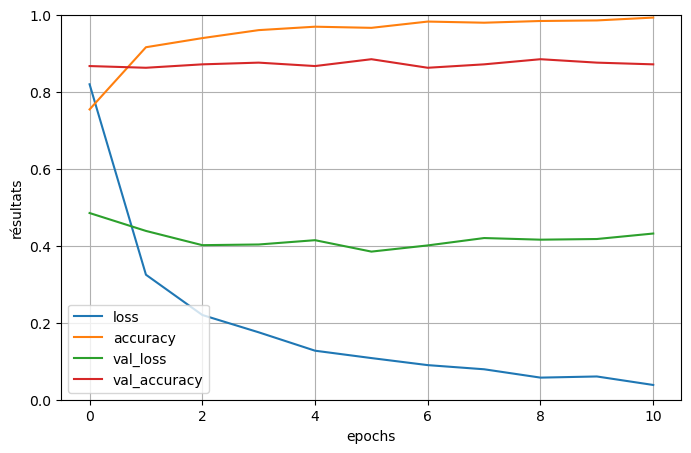

In [21]:
pd.DataFrame(history1.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [22]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

8/8 [==============================] - 27s 3s/step
[5 1 5 0 5 3 0 0 4 1]

[5 1 5 3 5 3 0 0 4 1]


In [23]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[20  1  1  4  2  0]
 [ 0 24  3  5  1  1]
 [ 0  0 33  0  1  0]
 [ 2  0  0 54  0  1]
 [ 0  2  1  1 31  0]
 [ 0  0  0  0  0 37]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.89      0.71      0.79        34
           2       0.87      0.97      0.92        34
           3       0.84      0.95      0.89        57
           4       0.89      0.89      0.89        35
           5       0.95      1.00      0.97        37

    accuracy                           0.88       225
   macro avg       0.89      0.87      0.88       225
weighted avg       0.89      0.88      0.88       225



In [24]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model1.predict(X_test), axis=1)
print(y_test_num)
print()
print(y_test_pred)

5/5 [==============================] - 14s 3s/step
[3 4 3 0 3 3 0 0 0 0 3 3 5 0 0 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 3 3
 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 1 4 0 0 3 0 0 0 3 3
 0 1 0 4 0 0 0 0 0 3 1 3 3 1 3 0 4 4 3 4 0 0 3 4 3 4 0 2 4 0 1 1 1 4 3 0 0
 3 1 0 2 1 3 2 2 3 2 3 2 2 2 3 3 2 3 1 1 2 3 2 2 2 3 1 3 0 0 0 0 0 0 0 0 0
 0]

[3 4 3 3 3 0 0 0 0 0 3 1 5 0 0 3 0 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 0 1 3 2
 3 3 3 3 3 1 3 3 1 3 1 3 3 3 3 0 3 1 1 3 3 3 3 3 3 3 3 1 4 3 3 3 3 3 0 3 3
 0 1 0 4 0 0 3 0 0 3 1 3 3 3 3 0 3 0 3 4 1 1 3 4 3 3 0 2 4 4 1 1 2 3 3 0 3
 3 1 0 2 1 3 2 2 3 2 3 2 2 2 3 3 2 3 1 1 2 3 2 2 2 3 0 3 3 3 3 3 3 3 3 3 3
 3]


In [25]:
conf_mat = confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)

print(classification_report(y_test_num, y_test_pred))

[[17  2  0 17  1  0]
 [ 1 12  1  1  0  0]
 [ 0  0 13  0  0  0]
 [ 4  4  1 63  0  0]
 [ 1  1  0  3  6  0]
 [ 0  0  0  0  0  1]]
              precision    recall  f1-score   support

           0       0.74      0.46      0.57        37
           1       0.63      0.80      0.71        15
           2       0.87      1.00      0.93        13
           3       0.75      0.88      0.81        72
           4       0.86      0.55      0.67        11
           5       1.00      1.00      1.00         1

    accuracy                           0.75       149
   macro avg       0.81      0.78      0.78       149
weighted avg       0.76      0.75      0.74       149



In [26]:
list_labels = df.category_name.unique()
list_labels
nb_classe = np.arange(0,6)
nb_classe

array([0, 1, 2, 3, 4, 5])

<AxesSubplot:>

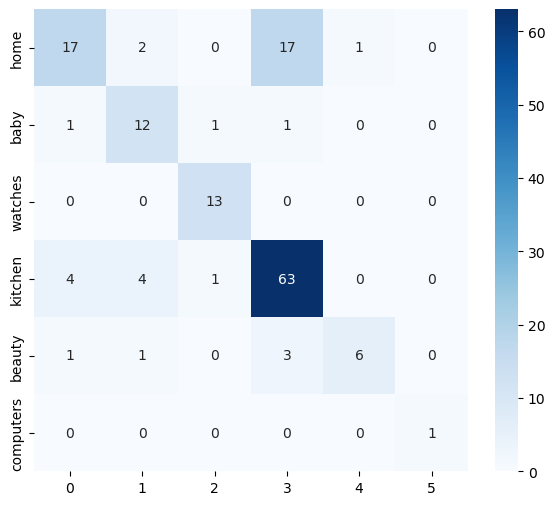

In [27]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in nb_classe])
plt.figure(figsize = (7,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## 2 Data augmentation 

In [28]:

dframe = {'path':img_path[:900],'label':df.label[:900].astype(str)}
dframe = pd.DataFrame(dframe)
dframe


dftest = {'path':img_path[901:1050],'label':df.label[901:1050].astype(str)}
dftest = pd.DataFrame(dftest)
dframe_test = dftest


#images_np = image_prep_fct(dframe)
#print(images_np.shape)

In [29]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='path', y_col='label',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [30]:
datagen_train = ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(dframe, datagen_train, data_type='training')
val_flow = data_flow_fct(dframe, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(validation_split=0,preprocessing_function=preprocess_input)
test_flow = data_flow_fct(dframe_test, datagen_test, data_type=None)


Found 675 validated image filenames belonging to 6 classes.
Found 225 validated image filenames belonging to 6 classes.
Found 149 validated image filenames belonging to 6 classes.


In [31]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_data__augmented_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [33]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=3, callbacks=callbacks_list, verbose=1)


Epoch 1/3
20/22 [==========================>...] - ETA: 7s - loss: 0.6763 - accuracy: 0.7938 

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


22/22 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.8044
Epoch 1: val_loss improved from inf to 0.74413, saving model to .\model2_data__augmented_weights.h5
22/22 [==============================] - 148s 6s/step - loss: 0.6552 - accuracy: 0.8044 - val_loss: 0.7441 - val_accuracy: 0.8400
Epoch 2/3
22/22 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.9170
Epoch 2: val_loss improved from 0.74413 to 0.50133, saving model to .\model2_data__augmented_weights.h5
22/22 [==============================] - 123s 6s/step - loss: 0.3061 - accuracy: 0.9170 - val_loss: 0.5013 - val_accuracy: 0.8622
Epoch 3/3
22/22 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9407
Epoch 3: val_loss did not improve from 0.50133
22/22 [==============================] - 121s 6s/step - loss: 0.2240 - accuracy: 0.9407 - val_loss: 0.5019 - val_accuracy: 0.8622


In [34]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

22/22 [==============================] - 83s 4s/step - loss: 0.1192 - accuracy: 0.9763
Training Accuracy   : 0.9763

8/8 [==============================] - 29s 3s/step - loss: 0.5192 - accuracy: 0.8489
Validation Accuracy :  0.8489


In [35]:
# chargement de la meilleur configuration
# Score de l'epoch optimal


model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8711
Test Accuracy       :  0.7248


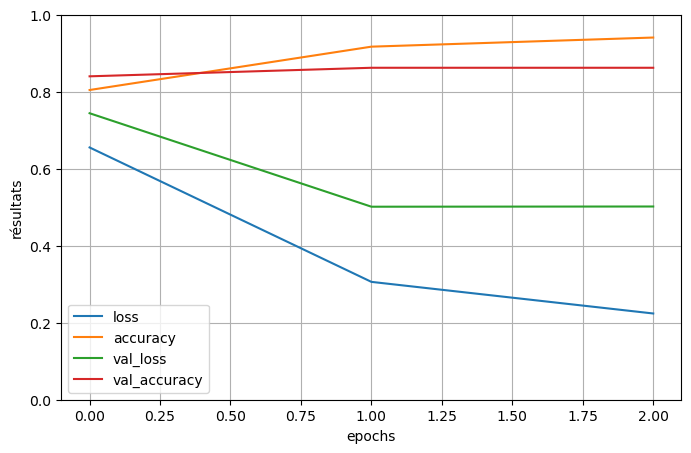

In [36]:
pd.DataFrame(history2.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [37]:
test_flow[0][0][0].shape

(256, 256, 3)

In [38]:
images_np_test[0].shape

(224, 224, 3)

In [39]:
val_flow.labels[:5]

[3, 0, 0, 3, 3]

In [40]:
y_val_num = train_flow.labels
y_val_pred = np.argmax(model2.predict(train_flow), axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

22/22 [==============================] - 92s 4s/step
[3, 3, 3, 3, 3, 3, 3, 3, 3, 4]

[5 0 4 2 0 2 3 5 3 1]


In [41]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[11  7 18 33  7 17]
 [14 21 16 27 12 26]
 [17 25 35 26  7 18]
 [27 30 32 33 14 29]
 [ 6 10 10 12  5  9]
 [16 19 18 37  6 25]]
              precision    recall  f1-score   support

           0       0.12      0.12      0.12        93
           1       0.19      0.18      0.18       116
           2       0.27      0.27      0.27       128
           3       0.20      0.20      0.20       165
           4       0.10      0.10      0.10        52
           5       0.20      0.21      0.20       121

    accuracy                           0.19       675
   macro avg       0.18      0.18      0.18       675
weighted avg       0.19      0.19      0.19       675



In [42]:
y_val_num = test_flow.labels
y_val_pred = np.argmax(model2.predict(test_flow), axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

5/5 [==============================] - 20s 4s/step
[3, 4, 3, 0, 3, 3, 0, 0, 0, 0]

[0 0 3 4 3 3 1 2 3 3]


In [43]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[ 5  4  5 18  4  1]
 [ 1  3  1 10  0  0]
 [ 2  1  2  6  2  0]
 [15 10  5 37  5  0]
 [ 3  1  1  6  0  0]
 [ 0  0  0  1  0  0]]
              precision    recall  f1-score   support

           0       0.19      0.14      0.16        37
           1       0.16      0.20      0.18        15
           2       0.14      0.15      0.15        13
           3       0.47      0.51      0.49        72
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         1

    accuracy                           0.32       149
   macro avg       0.16      0.17      0.16       149
weighted avg       0.31      0.32      0.31       149



### Data augmentation intégré au modèle

In [44]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def preprocess_input(image_path):
    # Add any preprocessing steps you need for your images
    # For example, you can load the image using tf.keras.preprocessing.image.load_img
    # and then convert it to an array using tf.keras.preprocessing.image.img_to_array
    return image_path

def dataset_fct(dframe, validation_split=0, data_type=None):
    datagen = ImageDataGenerator(
        validation_split=validation_split
    )

    target_size = (224, 224)  # Adjust the target size according to your needs

    if data_type == 'training':
        subset = 'training'
    elif data_type == 'validation':
        subset = 'validation'
    else:
        subset = None

    # Create the data generator using flow_from_dataframe
    data_flow = datagen.flow_from_dataframe(
        dataframe=dframe,
        directory='',  # Since we are providing the full file paths in the DataFrame
        x_col='path',  # Column containing image file paths
        y_col='label',  # Column containing labels
        batch_size=batch_size,
        class_mode='categorical',  # For one-hot encoded labels
        target_size=target_size,
        subset=subset,
        shuffle=True,  # Shuffle the data for training and validation
        seed=42
    )
    return data_flow


# Créer les datasets pour l'entraînement, la validation et les tests
train_flow = dataset_fct(dframe, validation_split=0.25, data_type='training')
val_flow = dataset_fct(dframe, validation_split=0.25, data_type='validation')
test_flow = dataset_fct(dframe_test, validation_split=0, data_type=None)


Found 675 validated image filenames belonging to 6 classes.
Found 225 validated image filenames belonging to 6 classes.
Found 149 validated image filenames belonging to 6 classes.


In [45]:
test_flow.next()[0].shape

(32, 224, 224, 3)

In [46]:
batch_size = 32
"""
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset"""

"\ndef dataset_fct(path, validation_split=0, data_type=None) :\n    dataset = tf.keras.utils.image_dataset_from_directory(\n                    path, labels='inferred', label_mode='categorical',\n                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,\n                    validation_split=validation_split, subset=data_type\n                    )\n    return dataset"

In [47]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = EfficientNetV2M(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(6, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model



In [48]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct2()

# Création du callback
model3_save_path = "Models/model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 7, 7, 1280)       53150388  
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [49]:
with tf.device('/gpu:0'): 
    history4 = model3.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=3, callbacks=callbacks_list, verbose=1)


Epoch 1/3
20/22 [==========================>...] - ETA: 6s - loss: 1.7703 - accuracy: 0.2095

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


22/22 [==============================] - ETA: 0s - loss: 1.7694 - accuracy: 0.2074
Epoch 1: val_loss improved from inf to 2.03147, saving model to Models\model3_best_weights.h5
22/22 [==============================] - 119s 4s/step - loss: 1.7694 - accuracy: 0.2074 - val_loss: 2.0315 - val_accuracy: 0.2800
Epoch 2/3
22/22 [==============================] - ETA: 0s - loss: 1.7917 - accuracy: 0.2222
Epoch 2: val_loss improved from 2.03147 to 1.97820, saving model to Models\model3_best_weights.h5
22/22 [==============================] - 91s 4s/step - loss: 1.7917 - accuracy: 0.2222 - val_loss: 1.9782 - val_accuracy: 0.2800
Epoch 3/3
22/22 [==============================] - ETA: 0s - loss: 1.7662 - accuracy: 0.2311
Epoch 3: val_loss improved from 1.97820 to 1.95194, saving model to Models\model3_best_weights.h5
22/22 [==============================] - 94s 4s/step - loss: 1.7662 - accuracy: 0.2311 - val_loss: 1.9519 - val_accuracy: 0.2756


In [50]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

22/22 [==============================] - 65s 3s/step - loss: 1.7402 - accuracy: 0.2459
Training Accuracy   : 0.2459

8/8 [==============================] - 22s 3s/step - loss: 1.9519 - accuracy: 0.2756
Validation Accuracy :  0.2756


In [51]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(train_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.2459
Test Accuracy       :  0.4832


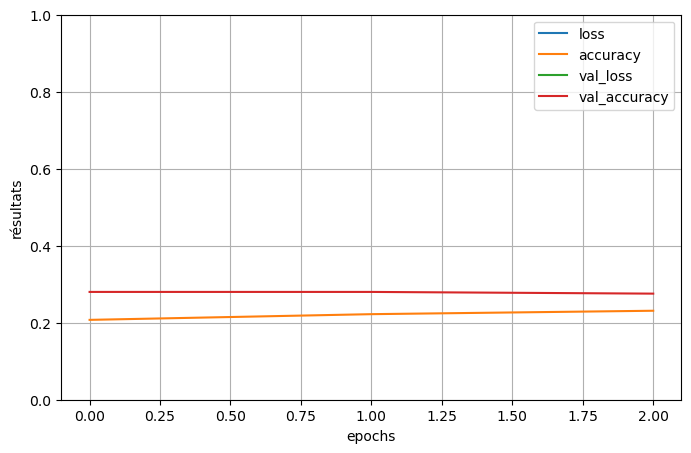

In [52]:
pd.DataFrame(history4.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [54]:
from tensorflow.keras import layers
import PIL

### 3. Classification supervisé des images avec le modèle EfficientNetV2M avec data augmentation 

### Creation de 1250 images augmentées

In [56]:
def image_prep_fct2(data) :

    img = load_img(data,target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    img = np.array(img)
        
    return img

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)


tab_img = np.zeros((1050,224,224,3))
for i in range(len(img_path)):
    
    tab_img[i] = np.array(load_img(img_path[i],target_size=(224, 224,3)))


y = to_categorical(df.label, num_classes=6)
X = tab_img
X_mean = X.mean(axis=0)
datagen.fit(X - X_mean)
data_augment = datagen.flow(X-X_mean, y, shuffle=False)

augmented_data = data_augment.x

In [58]:
tab_img_org = np.zeros((1050,224,224,3))
for i in range(len(img_path)):
    
    tab_img_org[i] = image_prep_fct2(img_path[i])


In [59]:
data_mix = np.concatenate([tab_img_org,augmented_data],axis = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


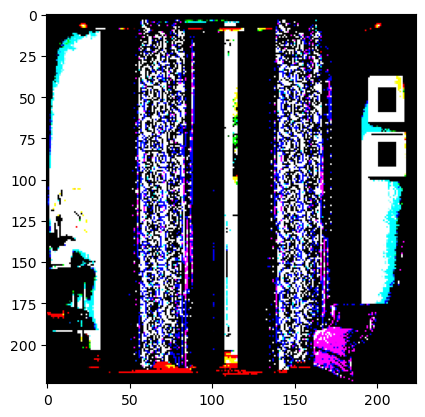

In [60]:
plt.imshow(data_mix[1050])

In [61]:
y1_augmented = df.label
y2 = df.label

y_ = np.concatenate([y1_augmented,y2],axis = 0)

In [62]:
len(y_)

2100

In [63]:
X = data_mix[:1600]
y = y_[:1600]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(1200, 224, 224, 3)

In [64]:
X_val.shape,y_val.shape

((400, 224, 224, 3), (400,))

In [65]:
X_test = data_mix[1601:2100]
y_test = y_[1601:2100]

In [66]:
y_train_encoded = to_categorical(y_train)

y_test_encoded = to_categorical(y_test)

y_val_encoded = to_categorical(y_val)

### Entrainement du modèle

In [67]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct()

# Création du callback
model4_save_path = "Models/model4_best_w.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_4[0][0]']            
                                )                                                                 
                                                                                            

In [68]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history4 = model4.fit(X_train, y_train_encoded, epochs=15, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val_encoded), verbose=1)



Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.7667
Epoch 1: val_loss improved from inf to 0.51115, saving model to Models\model4_best_w.h5
19/19 [==============================] - 184s 9s/step - loss: 0.7912 - accuracy: 0.7667 - val_loss: 0.5112 - val_accuracy: 0.8425
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8875
Epoch 2: val_loss improved from 0.51115 to 0.44015, saving model to Models\model4_best_w.h5
19/19 [==============================] - 158s 8s/step - loss: 0.4158 - accuracy: 0.8875 - val_loss: 0.4401 - val_accuracy: 0.8600
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.9075
Epoch 3: val_loss improved from 0.44015 to 0.38436, saving model to Models\model4_best_w.h5
19/19 [==============================] - 155s 8s/step - loss: 0.3059 - accuracy: 0.9075 - val_loss: 0.3844 - val_accuracy: 0.8700
Epoch 4/15
19/19 [==============================] - ETA:

### Evaluation du modèle

In [69]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(X_train, y_train_encoded, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(X_val, y_val_encoded, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

38/38 [==============================] - 115s 3s/step - loss: 0.0328 - accuracy: 0.9933
Training Accuracy: 0.9933

13/13 [==============================] - 38s 3s/step - loss: 0.3641 - accuracy: 0.8875
Validation Accuracy:  0.8875


In [70]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(X_val, y_val_encoded, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(X_test, y_test_encoded, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8875
Test Accuracy       :  0.8056


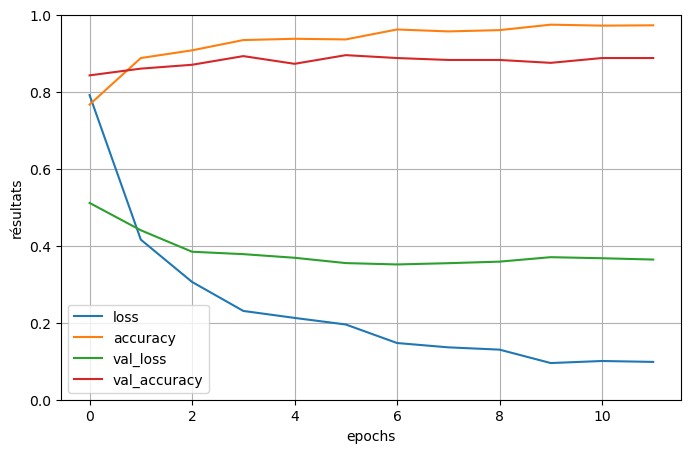

In [71]:
pd.DataFrame(history4.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [72]:
y_val_num = np.argmax(y_val_encoded, axis=1)
y_val_pred = np.argmax(model4.predict(X_val), axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

13/13 [==============================] - 44s 3s/step
[3 1 2 0 3 2 1 0 3 5]

[3 1 2 0 3 2 1 3 3 5]


In [73]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[37  1  0  9  0  1]
 [ 0 52  1  6  0  2]
 [ 0  2 56  1  1  0]
 [ 5  4  0 94  1  0]
 [ 0  5  1  3 59  0]
 [ 0  0  0  1  1 57]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        48
           1       0.81      0.85      0.83        61
           2       0.97      0.93      0.95        60
           3       0.82      0.90      0.86       104
           4       0.95      0.87      0.91        68
           5       0.95      0.97      0.96        59

    accuracy                           0.89       400
   macro avg       0.90      0.88      0.89       400
weighted avg       0.89      0.89      0.89       400



In [78]:
y_test_num = np.argmax(y_test_encoded, axis=1)
y_test_pred = np.argmax(model4.predict(X_test), axis=1)
print(y_test_num[:10])
print()
print(y_test_pred[:10])

16/16 [==============================] - 47s 3s/step
[5 5 5 5 5 5 5 5 5 5]

[5 5 5 5 5 5 5 5 5 5]


In [75]:
conf_mat = confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)

print(classification_report(y_test_num, y_test_pred))

[[ 76   4   4  21   1   2]
 [  2  46   0   9   0   1]
 [  1   1  49   5   0   2]
 [  5   8  14 153   1   3]
 [  1   3   1   3  20   0]
 [  0   1   1   2   1  58]]
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       108
           1       0.73      0.79      0.76        58
           2       0.71      0.84      0.77        58
           3       0.79      0.83      0.81       184
           4       0.87      0.71      0.78        28
           5       0.88      0.92      0.90        63

    accuracy                           0.81       499
   macro avg       0.81      0.80      0.80       499
weighted avg       0.81      0.81      0.81       499



In [76]:
list_labels = df.category_name.unique()
list_labels
nb_classe = np.arange(0,6)
nb_classe

array([0, 1, 2, 3, 4, 5])

<AxesSubplot:>

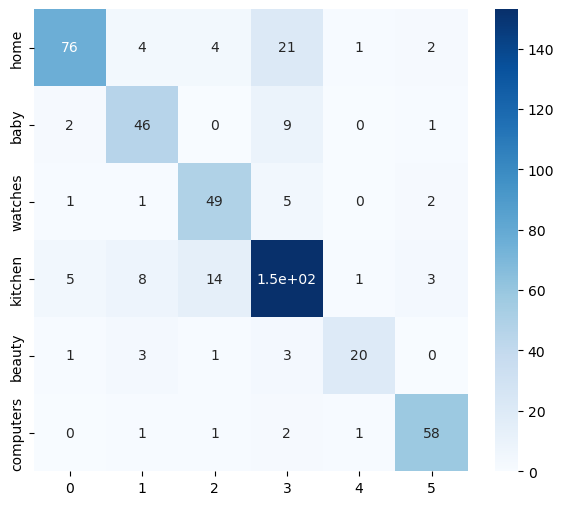

In [77]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in nb_classe])
plt.figure(figsize = (7,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")